## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore")

## 1. Carga datos y representa la serie

In [3]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates=['date'], index_col = 'date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.describe()

,value
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [6]:
df.isnull().sum()   

value    0
dtype: int64

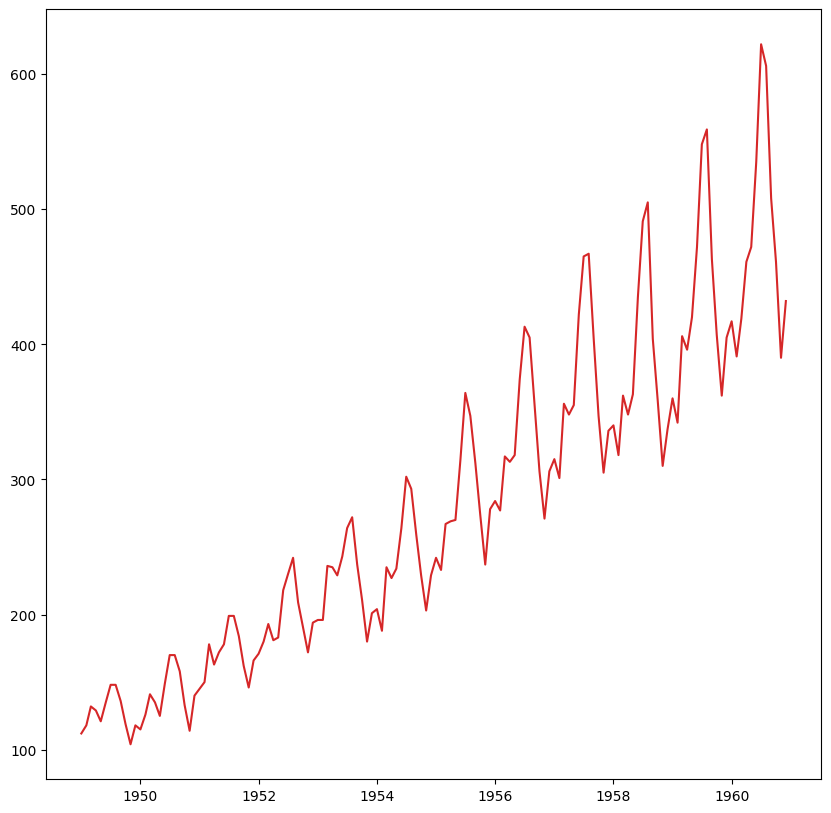

In [7]:
# plot date / value

def plot_df(df, x, y, title="", xlabel='date', ylabel='value', dpi=100):
    plt.figure(figsize=(10,10))
    plt.plot(x, y, color='tab:red')
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly Air Passengers')

**Seasonal decomposition and Autocorrelation**


* **Seasonal decomposition** helps reveal and understand the different components driving the patterns in the time series, like trend, seasonality, and noise. This provides insight into the data and can improve forecast accuracy by modeling these components separately.

* **Autocorrelation** measures the correlation between a time series and lagged versions of itself. This helps detect serial dependence and non-stationarity. High autocorrelation may require differencing or other transformations to stationarize the data before modeling.

Knowing the autocorrelation structure helps identify appropriate time series models. (*For example, ARIMA models directly model the autocorrelation in the data.)*

**Seasonal_decompose,** decomposes the 'value' time series
 into multiplicative **trend, seasonal, and residual components,**
 assuming a repeating trend.
   It splits the data into these underlying patterns.

* **The seasonal component** shows the repeating short-term cycles or patterns in the data. For example, hourly, daily, weekly, monthly, or annual seasons.

* **The magnitude**of the seasonal component indicates the strength of the seasonal effect. Larger fluctuations represent stronger seasonal cycles.

* **The peaks and troughs** show the high and low points of the seasonal cycle. Looking at the timing and duration between peaks gives the period of the seasonality.

* **Steady oscillations of fixed period and amplitude** imply a stable seasonal pattern. The seasonality is consistent over time.

* **Changes in amplitude** could mean the strength of the seasonal effect is increasing or decreasing. The peaks are getting higher or lower over time.

* ****A phase shift ****where peaks shift earlier or later could indicate a change in timing of the seasonal cycle.

* **Irregular ups and downs** suggest a less defined seasonal pattern. The cycles are not very periodic.

* ****A flat line ****means minimal or no discernible seasonality in the data.



In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose



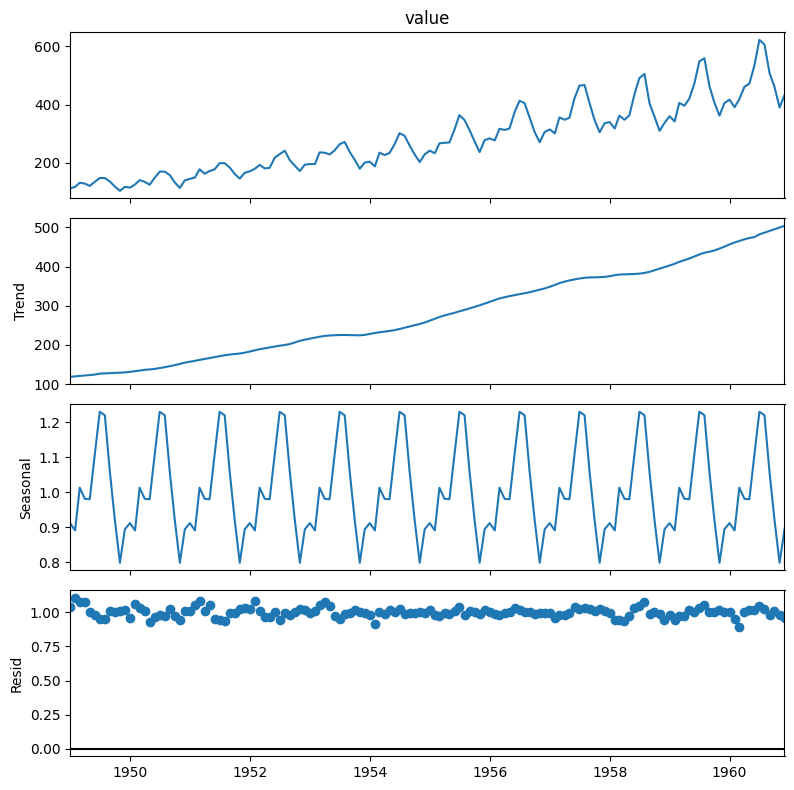

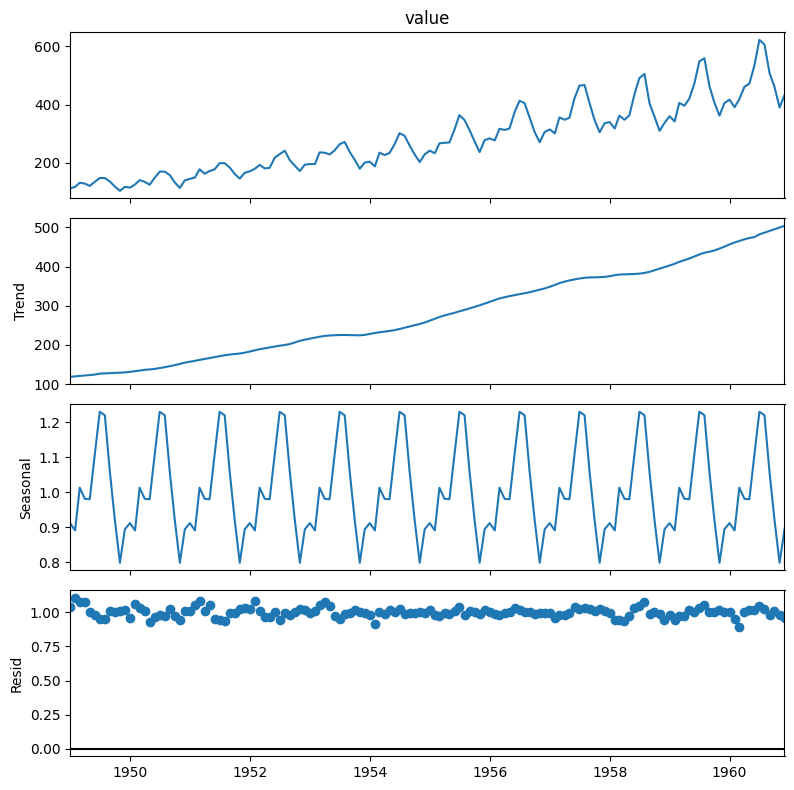

In [9]:
# decompose "value" 

'''The 'multiplicative' model assumes
 the components multiply together 
 to give the original data. 
 The 'freq' trend extrapolation repeats the
   last actual value into the future.'''

decomposed = seasonal_decompose(df['value'], model='multiplicative',extrapolate_trend='freq')

# Break down the time series into its underlying components 
plt.rcParams.update({'figure.figsize': (8, 8)})
decomposed.plot()


Autocorrelation'df['value']'.

* The autocorrelation plot shows the correlation between the time series and lagged versions of itself. 

* This can help **identify cyclical patterns or seasonality in the data.**

* The lag axix specifies the number of lags to calculate autocorrelation for. It ranges from 0 to n-1, where n is the number of observations. 144 observations (12 years of monthly data).
lag goes from 0 to 143 to calculate autocorrelation at each lag up to 143 steps back.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

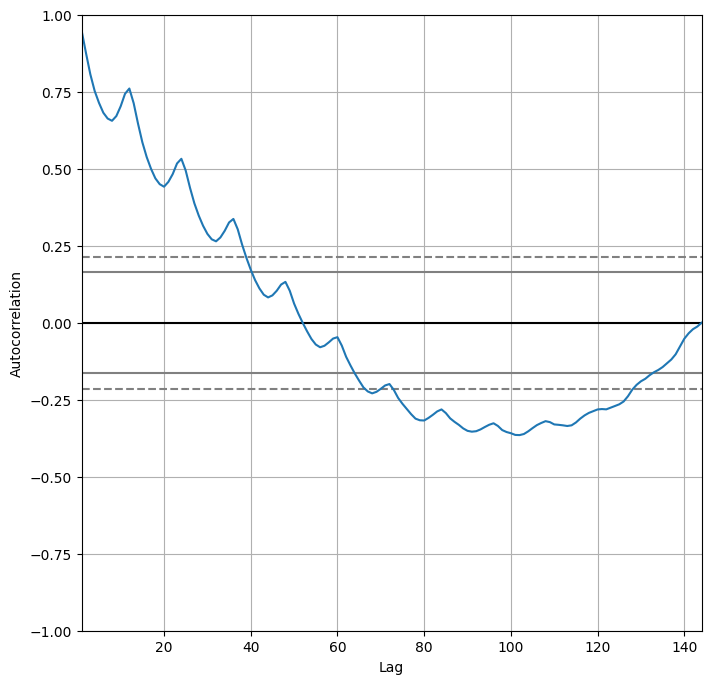

In [10]:

from pandas.plotting import autocorrelation_plot 
autocorrelation_plot(df['value']) 


## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior

* *df.rolling(s, center=True, closed='both').mean()*

* **The rolling() method** lets you calculate statistics like the average over the rows within your current window. So as your window "rolls" down the dataframe, you get the average calculated on just the rows in your current view.

* **s parameter** lets you set how wide your window is - how many rows it covers. So s=5 would be a window 5 rows wide.

* **center=True** means the window is centered on the current row. So you're looking at the current row, s/2 rows before, and s/2 rows ahead.

* **closed='both'** means the window includes the first and last row its spanning across.








<AxesSubplot: xlabel='date'>

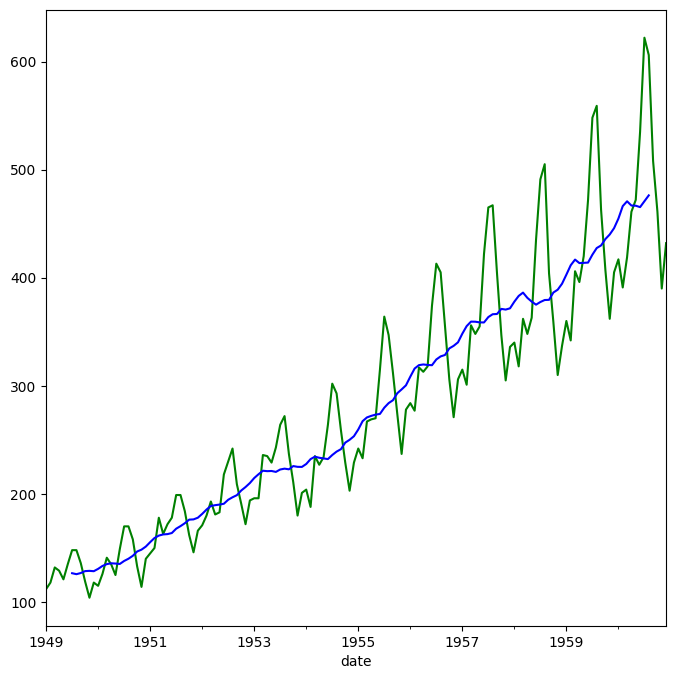

In [11]:
'''Calculate the rolling mean (average)
 over s rows in a window centered on
   the current row. 
   As the window rolls down,
     the mean is computed over that window slice, hence rolling.'''


rolling_mean = df['value'] .rolling(12, center=True, closed='both').mean()# 12 months of data

df['value'].plot(color='g') # plot "value" in green
rolling_mean.plot(color = 'b') # plot "rolling_mean" in blue

## 3. Comprueba de manera estadística si la serie es o no stationary.

El test estadístico es positivo, lo cual implica que es mucho menos probable que rechacemos la hipótesis nula (no estacionaria).

Al comparar el estadístico ADF con los valores críticos, parece que no podríamos rechazar la hipótesis nula de que la serie temporal no es estacionaria y en consecuencia afirmamos que la serie tiene una estructura que sí que es dependiente del tiempo.

Un valor p por encima del umbral sugiere que no rechazamos la hipótesis nula (no estacionario).

**adfuller(df['value'])**

* The ADF Statistic is the actual calculated test statistic. The more negative it is, ***the stronger the rejection of the null hypothesis that the series has a unit root (is non-stationary).***

* **The p-value** is the probability of obtaining a test statistic as extreme as the one calculated, assuming the null hypothesis is true. If **below a threshold like 0.05, the p-value suggests rejecting the null.**

**The Critical Values** are the threshold test statistic values to compare against. If the **ADF Statistic is below the Critical Value, the null hypothesis is rejected.**


* test[0] is the ADF test statistic<br>
* test[1] is the p-value<br>
* test[4] is a dictionary containing the critical values


In [12]:
# Augmented Dickey-Fuller test to check for stationarity

from statsmodels.tsa.stattools import adfuller


In [13]:
# Augmented Dickey-Fuller test on the 'value' column 

Fuller_test_log = adfuller(df['value'])



In [14]:
# ADF statistic 
print( "ADA Statistic: ",Fuller_test_log[0])

ADA Statistic:  0.8153688792060472


In [15]:
# P-Value
print("P-Value:",Fuller_test_log[1])

P-Value: 0.991880243437641


In [16]:
# Critical Values
for x, i in Fuller_test_log[4].items():
    print("Critical Values:", (x, i))

Critical Values: ('1%', -3.4816817173418295)
Critical Values: ('5%', -2.8840418343195267)
Critical Values: ('10%', -2.578770059171598)


<AxesSubplot: xlabel='date'>

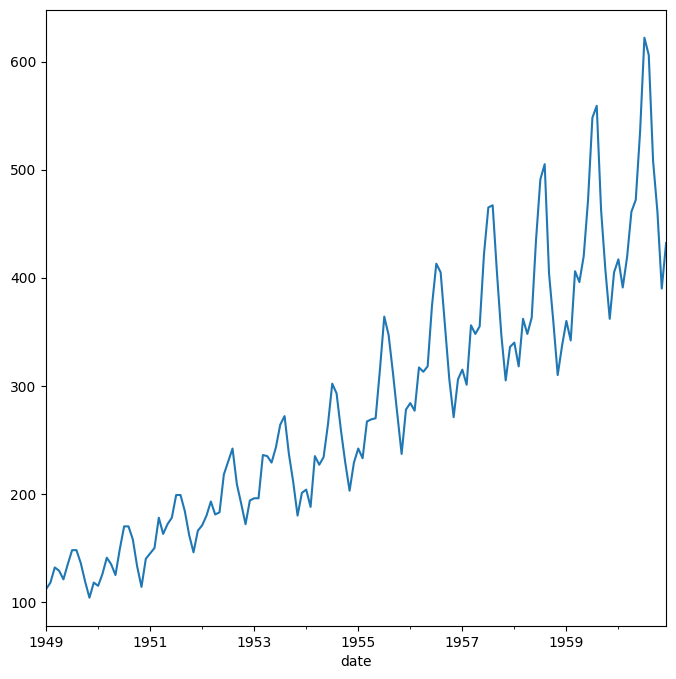

In [17]:
df['value'].plot()  

**Seasonal decomposition and Autocorrelation**


* **Seasonal decomposition** helps reveal and understand the different components driving the patterns in the time series, like trend, seasonality, and noise. This provides insight into the data and can improve forecast accuracy by modeling these components separately.

* **Autocorrelation** measures the correlation between a time series and lagged versions of itself. This helps detect serial dependence and non-stationarity. High autocorrelation may require differencing or other transformations to stationarize the data before modeling.

Knowing the autocorrelation structure helps identify appropriate time series models. (*For example, ARIMA models directly model the autocorrelation in the data.)*

## 4. Aplica una transformación logarítmica

Podemos ver que el valor es mayor que los valores críticos, lo que significa que podemos rechazar la hipótesis nula y, a su vez, que la serie de tiempo no es estacionaria.

Sin embargo nos sigue interesando aplicar la transformación porque conseguimos estabilizar la varianza.

**Pre-processing / Normalization np.log()**

* Necessary as a preprocessing step before modeling time series data. 

* **Making trends linear** - Many time series have exponential trends, either growth or decay. Taking the log transforms the data so that exponential trends appear linear, which is more amenable to modeling with linear techniques.

* **Stabilizing variance** - Time series data frequently exhibits changing variability over time. Taking the log can help stabilize the variance so that the data has more constant variability, an assumption made by many models.

* **Making data normal** - Financial and economic time series often have positive skews. The log transform can make the distribution more symmetrical and normal. Many modeling techniques assume normality.

* **Compressing range** - In some cases one or more extreme values can dominate the scale. Taking the log compresses the range so that extreme values don't have as much influence.

* **Simplifying relationships** - Log-linear relationships are common in time series. Taking the log allows modeling the data with linear rather than more complex nonlinear models.

* It helps uncover patterns that may not be visible on the original scale. This allows building better models for prediction and forecasting tasks.



 

In [18]:

# Transforms data to be more normally distributed.
df['value'] = np.log(df['value'])
#  Apply the Augmented Dickey-Fuller testfrom sklearn.model_selection import train_test_split

Fuller_test_log = adfuller(df['value'])


In [19]:
# ADF Statistic
print('ADF Statistic(log):',Fuller_test_log[0])

ADF Statistic(log): -1.7170170891069605


In [20]:
# p-value
print('P-value(log):' , Fuller_test_log[1])

P-value(log): 0.42236677477039125


In [21]:
# Critical values
for x,i  in Fuller_test_log[4].items():
    print("Critical values(log)", (x, i))

Critical values(log) ('1%', -3.4816817173418295)
Critical values(log) ('5%', -2.8840418343195267)
Critical values(log) ('10%', -2.578770059171598)


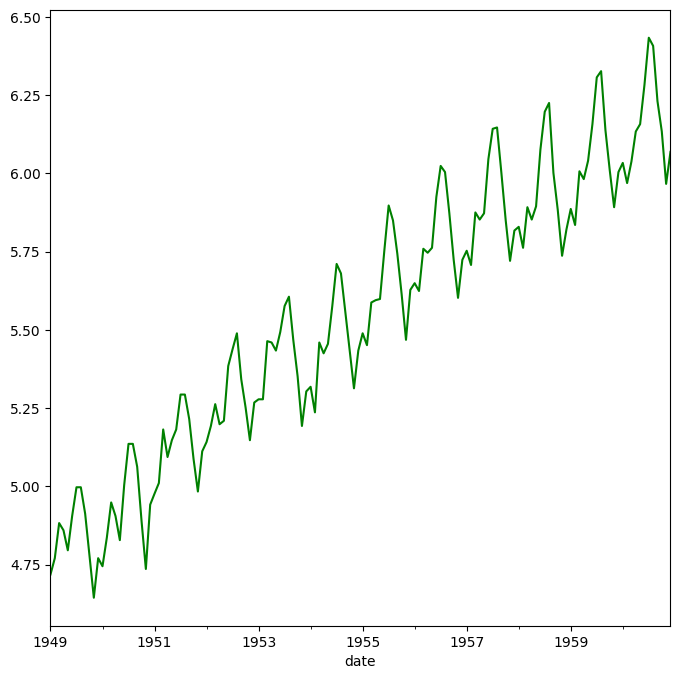

In [22]:
# chech variance after np.log 
df['value'].plot(color='g');

## 5. Divide en train y test. Guarda 20 muestras para test.

* Total 144 entries, 124 para train y 20 para test

In [23]:
# trainig set = first 125 rows of the 'value' 
train = df['value'][0:125]
# test set = remaining rows of the 'value'   
test = df['value'][125:]
 

## 6. Crea tu primer modelo ARIMA

In [24]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

* **ARIMA model on non-stationary** time series data without differencing, it means we are training the model directly on the raw data even if it has trends and seasonality.

* Usually for ARIMA, we take first differences of the data (d=1) to make it stationary before modeling. However, setting **stationary=False** tells auto_arima to skip that differencing step.

**Training ARIMA on non-stationary data:**

* The model will try to directly learn the trends and seasonality rather than just short-term correlations. This often leads to worse forecasts.

* It can be harder for the model to distinguish between long term patterns vs short term dynamics.

 * Without stationary" means directly modeling the unstable time series, which violates ARIMA assumptions and often gives poor forecasting accuracy. Transforming to stationarity first is preferred.





**ARIMA parameters:**

**train**- The training time series data to fit the model on. This should be stationary.

**start_p**- The starting value to test for AR terms (p). 1 is a good default.

**start_q** - The starting value to test for MA terms (q). 1 is a good default.

**max_d** - The maximum number of differences to allow (d). This is often 0 or 1 on already stationary data.

**max_p** - The maximum AR order to test. 5 is a typical max value.

**max_q** - The maximum MA order to test. 5 is a typical max value.

**stationary** - Whether to first difference the data to make it stationary. True is recommended.

**warnings** - Whether to display warnings during model fitting. False suppresses warnings.

**error_action** - What to do if model errors occur. 'ignore' continues.

**trace** - Whether to print status during model fitting. Useful for debugging.

**stepwise** - Whether to use stepwise model selection process to minimize AIC. True is recommended.

In [25]:
# Without stationary" directly modeling the unstable time series
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,# max
                    max_q=5,# max
                    stationary=False,
                    warnings=False,
                    error_action = 'ignore',
                    trace=True,
                    stepwise=True)
print(model.aic())

predictions = model.predict(19)



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-211.160, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-203.811, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-205.275, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-206.552, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-204.531, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-206.463, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-228.437, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-232.456, Time=1.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-230.906, Time=1.91 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-236.640, Time=0.97 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-216.484, Time=0.61 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-235.7

**ARIMA(4,1,2)(0,0,0)[0] intercept**

* Lowest AIC value of -236.64

***(4,1,2)** 4 AR terms, 1 differencing term, and 2 MA terms for the non-seasonal part.

*  **(0,0,0)** = no seasonal components.The model has fewer parameters to estimate and is simpler to interpret. This can help avoid overfitting.

[0] = no seasonal period.

* The low AIC indicates it is efficiently capturing the core dynamics in the data.

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


* MSE, RMSE, MAE

In [27]:
print("MSE:", mean_squared_error(test.values, predictions))
print("RMSE:", np.sqrt(mean_squared_error(test.values, predictions)))
print("MAE:", mean_absolute_error(test.values, predictions))

MSE: 0.023534079452141234
RMSE: 0.15340821181456107
MAE: 0.13237854332607438


* **MSE 0.023**, The MSE is relatively low, showing the errors have small variance around zero. A lower value indicates a better fit.

* ***RMSE 0.153***. The standard deviation of the errors is fairly small in magnitude , indicating errors are not deviating too far from the actuals. Again, lower generally indicates better model performance.

* **MAE 0.132**. The average magnitude of error, or average error, is relatively low, indicating the errors are not deviating too far from the actuals. Again, lower generally indicates better model performance.

*Ideally the RMSE and MAE would be as close to 0 as possible, but values <0.2 generally suggest decent performance for most business time series.*

In [28]:
'''
Minimizing the AIC(Akaike Information Criterion)
'''

model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m=12,#seasonal period of 12.
                    stationary=False,
                    warnings=False,
                    error_action = 'ignore',
                    trace=True,
                   stepwise=True)
print(model.aic())

predictions = model.predict(19)



Performing stepwise search to minimize aic


 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-413.869, Time=6.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-294.133, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-403.899, Time=5.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-357.432, Time=1.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-126.477, Time=0.12 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-415.947, Time=2.40 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-388.347, Time=0.62 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-414.039, Time=10.54 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-409.560, Time=2.22 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-412.360, Time=6.38 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-412.579, Time=1.03 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-415.211, Time=2.99 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-414.401, Time=2.15 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-304.397, Time=0.38 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=-389.923, Time=0.9

In [29]:
print("MSE:", mean_squared_error(test.values, predictions))
print("RMSE:", np.sqrt(mean_squared_error(test.values, predictions)))
print("MAE:", mean_absolute_error(test.values, predictions))

MSE: 0.0020429812855843506
RMSE: 0.04519935049958518
MAE: 0.03495443216720011


In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  125
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 213.390
Date:                              Sun, 11 Feb 2024   AIC                           -416.779
Time:                                      11:13:47   BIC                           -403.143
Sample:                                  01-01-1949   HQIC                          -411.246
                                       - 05-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0197      0.010      2.048      0.041       0.001       0.039
ar.L1          0.6072      0.086      7.098      0.000       0.440       0.775
ar.L2          0.2315      0.090      2.586      0.010       0.056       0.407
ma.S.L12      -0.5595      0.116     -4.812      0.000      -0.787      -0.332
sigma2         0.0013      0.000      7.775      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.09
Prob(Q):                              0.98   Prob(JB):                         0.08
Heteroskedasticity (H):               0.41   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 7. Representa en una gráfica los datos de test y tus predicciones.

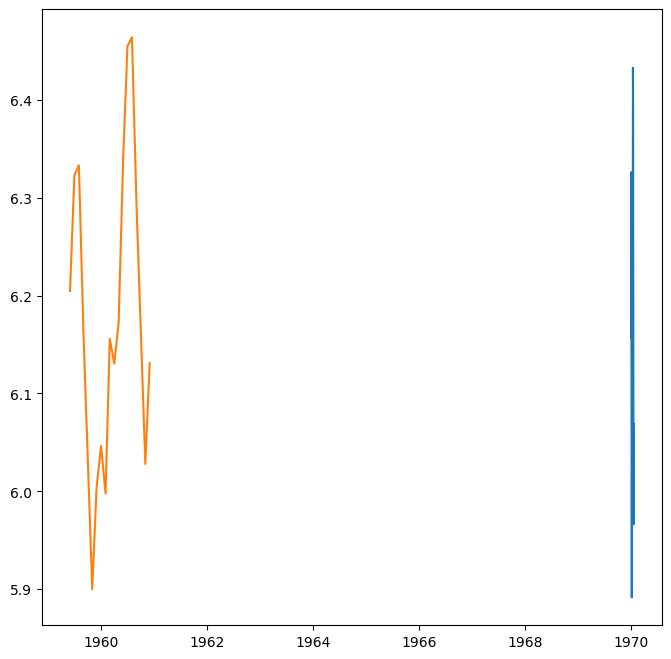

In [31]:
plt.plot(test.values)
plt.plot(predictions)

## 8. Prueba otros modelos, a ver qué performance presentan.

In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [33]:
df.head()

,value
date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


In [34]:
# trainig set = first 125 rows of the 'value' 
train = df['value'][0:125]
# test set = remaining rows of the 'value'   
test = df['value'][125:]

In [39]:
# Extract training data / reshape
X_train = train.values.reshape(-1, 1) 
y_train = train.values.reshape(-1, 1)

# Extract testing data / reshape
X_test = test.values.reshape(-1, 1)  
y_test = test.values.reshape(-1, 1) 

# DecisionTreeRegressor)
model = DecisionTreeRegressor()

# Train model on training data 
model.fit(X_train, y_train)

# predictions on test set
y_pred = model.predict(X_test)

In [36]:
# MSE,RMSE,MAE
print("DecisionTreeRegressor Results:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))


DecisionTreeRegressor Results:
MSE: 0.005154107536562778
RMSE: 0.07179211333122029
MAE: 0.03828620332468498


ARIMA results:

MSE: 0.0020429812855843506<br>
RMSE: 0.04519935049958518<br>
MAE: 0.03495443216720011

In [50]:
import xgboost as xgb


# model XGB regressor
model = xgb.XGBRegressor()

# Train model on training data
model.fit(X_train, y_train)

# predictions on test 
y_pred = model.predict(X_test)



In [53]:
# MSE,RMSE,MAE
print("xboost Results:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))


xboost Results:
MSE: 0.006007180195526161
RMSE: 0.07750600102912136
MAE: 0.05151147203753642


ARIMA results:

MSE: 0.0020429812855843506<br>
RMSE: 0.04519935049958518<br>
MAE: 0.03495443216720011

In [56]:
from sklearn.linear_model import LinearRegression


# model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Prediction
y_pred = lin_reg.predict(X_test)



In [57]:
# MSE,RMSE,MAE
print("Linear Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))


Linear Regression Results:
MSE: 0.0
RMSE: 0.0
MAE: 0.0
